## Testing out BRIA Background Removal v1.4 Model
#### https://huggingface.co/briaai/RMBG-1.4

These stats from training data are relevant to my use case:
- Objects only:	45.11%
- Photorealistic:	87.70%
- Single main foreground object:	51.42%
- Solid Background:	47.95%

In [1]:
pip install -qr https://huggingface.co/briaai/RMBG-1.4/resolve/main/requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Method 1 - load the pipeline

In [2]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


##### cell below is the code copied from documentation

In [3]:
from transformers import pipeline
image_path = "https://farm5.staticflickr.com/4007/4322154488_997e69e4cf_z.jpg"
pipe = pipeline("image-segmentation", model="briaai/RMBG-1.4", trust_remote_code=True)
pillow_mask = pipe(image_path, return_mask = True) # outputs a pillow mask
pillow_image = pipe(image_path) # applies mask on input and returns a pillow image


Device set to use mps:0


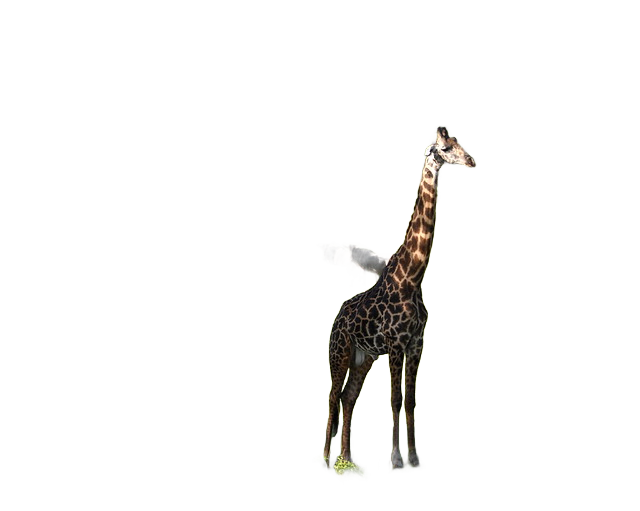

In [4]:
display(pillow_image)

##### test on my image

In [5]:
test_image_path = 'https://images.metmuseum.org/CRDImages/md/web-large/tr462-2010s2.jpg'

pillow_mask = pipe(test_image_path, return_mask = True) # outputs a pillow mask
pillow_image = pipe(test_image_path) # applies mask on input and returns a pillow image

Save images to folder

In [6]:
import os

testObjectId = "479496"
output_path = "../public/data/initial_test/BRIA/"

filename_mask = output_path + testObjectId + "mask.png"

if not os.path.exists(filename_mask):
    pillow_mask.save(filename_mask)
else:
    print(f"Skipped: {filename_mask} already exists.")


filename_no_bg = output_path + testObjectId + "_no_bg.png"

if not os.path.exists(filename_no_bg):
    pillow_image.save(filename_no_bg)
else:
    print(f"Skipped: {filename_no_bg} already exists.")

Skipped: ../public/data/initial_test/BRIA/479496mask.png already exists.
Skipped: ../public/data/initial_test/BRIA/479496_no_bg.png already exists.


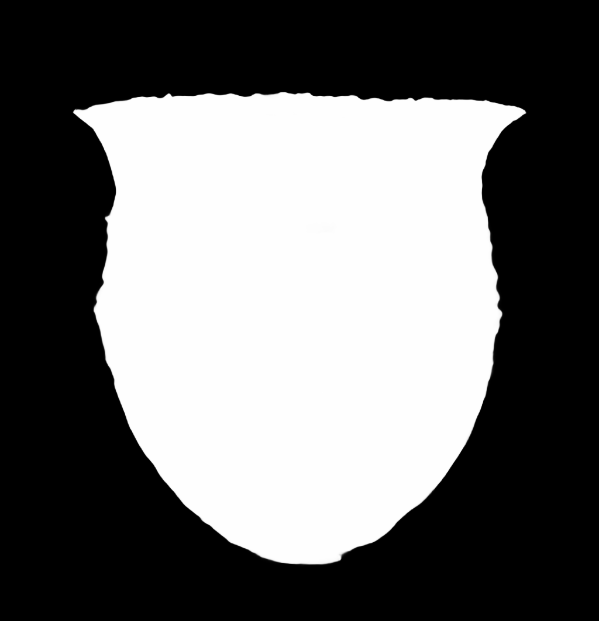

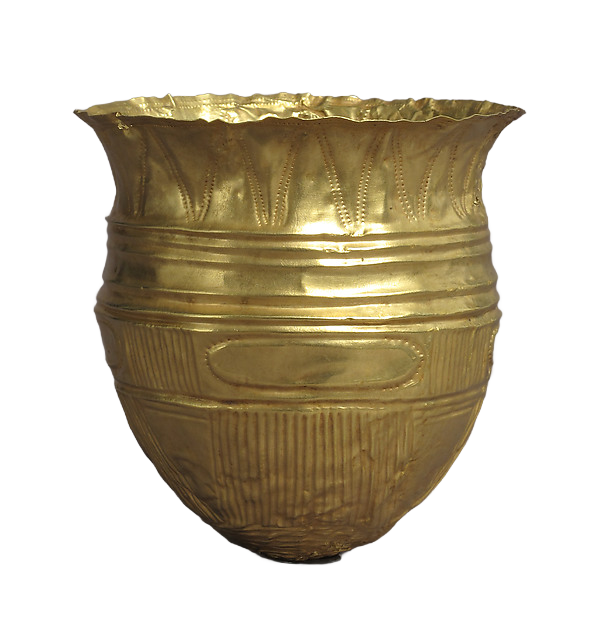

In [7]:
display(pillow_mask)
display(pillow_image)

##### test on 5 vase images

In [ ]:
import json
with open("../public/data/initial_test/imageUrls.json", "r") as f:
    data = json.load(f)

In [14]:
print(data)

[{'objectId': '447776', 'imageUrl': 'https://images.metmuseum.org/CRDImages/is/web-large/sf24-85a.jpg'}, {'objectId': '771036', 'imageUrl': 'https://images.metmuseum.org/CRDImages/es/web-large/DP-16489-273.jpg'}, {'objectId': '477748', 'imageUrl': 'https://images.metmuseum.org/CRDImages/md/web-large/cop0222s1.jpg'}, {'objectId': '48575', 'imageUrl': 'https://images.metmuseum.org/CRDImages/as/web-large/DP-15452-031.jpg'}, {'objectId': '548324', 'imageUrl': 'https://images.metmuseum.org/CRDImages/eg/web-large/DP276160.jpg'}]


In [15]:
def save_BRIA_images(obj, folderpath):
    image_path = obj["imageUrl"]
    objectId = obj["objectId"]

    pillow_mask = pipe(image_path, return_mask = True) # outputs a pillow mask
    pillow_image = pipe(image_path) # applies mask on input and returns a pillow image

    filename_mask = folderpath + objectId + "mask.png"
    if not os.path.exists(filename_mask):
        pillow_mask.save(filename_mask)
    else:
        print(f"Skipped: {filename_mask} already exists.")


    filename_no_bg = folderpath + objectId + "_no_bg.png"
    if not os.path.exists(filename_no_bg):
        pillow_image.save(filename_no_bg)
    else:
        print(f"Skipped: {filename_no_bg} already exists.")

In [16]:
for obj in data:
    save_BRIA_images(obj, output_path)

#### Method 2 - load the model

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torchvision.transforms.functional import normalize
from skimage import io
from PIL import Image

In [ ]:
# print(torch.cuda.is_available())
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# https://medium.com/%40ynikose/removing-backgrounds-with-briaais-rmbg-1-4-and-transformers-3c7e455c4d42
# https://rockyshikoku.medium.com/highest-level-background-removal-rmbg-1-4-12f8822d9599
model_input_size = [1024, 1024]


##### cell below is the code copied from documentation

note: only able to get image mask from here - see note about error below

In [ ]:
from transformers import AutoModelForImageSegmentation
from torchvision.transforms.functional import normalize
model = AutoModelForImageSegmentation.from_pretrained("briaai/RMBG-1.4",trust_remote_code=True)
def preprocess_image(im: np.ndarray, model_input_size: list) -> torch.Tensor:
    if len(im.shape) < 3:
        im = im[:, :, np.newaxis]
    # orig_im_size=im.shape[0:2]
    im_tensor = torch.tensor(im, dtype=torch.float32).permute(2,0,1)
    im_tensor = F.interpolate(torch.unsqueeze(im_tensor,0), size=model_input_size, mode='bilinear')
    image = torch.divide(im_tensor,255.0)
    image = normalize(image,[0.5,0.5,0.5],[1.0,1.0,1.0])
    return image

def postprocess_image(result: torch.Tensor, im_size: list)-> np.ndarray:
    result = torch.squeeze(F.interpolate(result, size=im_size, mode='bilinear') ,0)
    ma = torch.max(result)
    mi = torch.min(result)
    result = (result-mi)/(ma-mi)
    im_array = (result*255).permute(1,2,0).cpu().data.numpy().astype(np.uint8)
    im_array = np.squeeze(im_array)
    return im_array

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# prepare input
image_path = "https://farm5.staticflickr.com/4007/4322154488_997e69e4cf_z.jpg"
orig_im = io.imread(image_path)
orig_im_size = orig_im.shape[0:2]
image = preprocess_image(orig_im, model_input_size).to(device)

# inference 
result=model(image)

# post process
result_image = postprocess_image(result[0][0], orig_im_size)

# save result
pil_mask_im = Image.fromarray(result_image)

# NOTE - the next line is throwing an error - unhappy about the file path - works for locally saved images but not for remote
# orig_image = Image.open(image_path)
# no_bg_image = orig_image.copy()
# no_bg_image.putalpha(pil_mask_im)


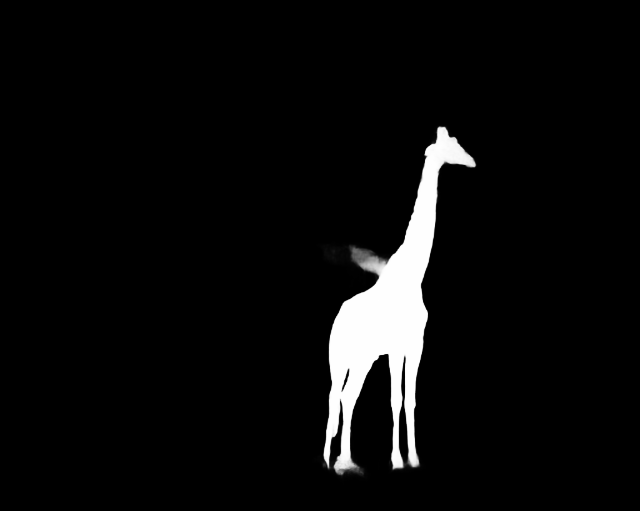

In [44]:
display(pil_mask_im)

#### test on my image

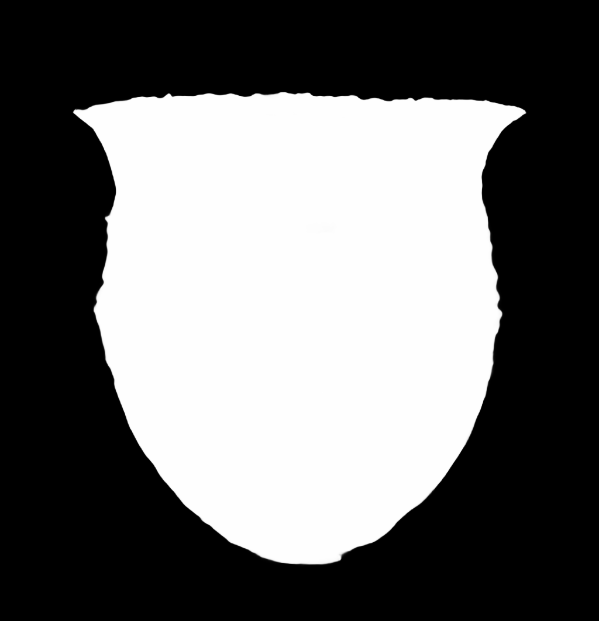

In [51]:
# url saved in this variable from above -
# test_image_path

orig_im_test = io.imread(test_image_path)
orig_im_size_test = orig_im_test.shape[0:2]
image_test = preprocess_image(orig_im_test, model_input_size).to(device)

# inference 
result=model(image_test)

# post process
result_image_test = postprocess_image(result[0][0], orig_im_size_test)

# save result
pil_mask_im_test = Image.fromarray(result_image_test)

display(pil_mask_im_test)